In [1]:
import pandas as pd

import xgboost as xgb

import seaborn as sns

import optuna
import optuna_integration

from sklearn.metrics import roc_auc_score

from math import sqrt

from datetime import datetime

#### Load data

In [2]:
Y_train = pd.read_csv("../../data/ld50/train.csv")["Class"]
Y_test = pd.read_csv("../../data/ld50/test.csv")["Class"]
Y_valid = pd.read_csv("../../data/ld50/valid.csv")["Class"]

X_train = pd.read_csv("train_embeddings.csv")
X_test = pd.read_csv("test_embeddings.csv")
X_valid = pd.read_csv("valid_embeddings.csv")

class_labels = ["Alto", "Moderado", "Leve", "Desprezível"][::-1]

#### Train

In [3]:
from sklearn.utils.class_weight import compute_sample_weight

train_sample_weight = compute_sample_weight(class_weight='balanced', y=Y_train)
valid_sample_weigth = compute_sample_weight(class_weight='balanced', y=Y_valid)
test_sample_weight = compute_sample_weight(class_weight='balanced', y=Y_test)

In [7]:
best_model = None
best_eval_metric = float("inf")

def objective(trial):
    global best_model
    global best_eval_metric

    model = xgb.XGBClassifier(
        verbosity=0,

        objective= 'multi:softprob',
        eval_metric='mlogloss',
        n_estimators=5000,
        num_class=len(Y_train.unique()),
        
        max_depth=trial.suggest_int('max_depth', 2, 6), 
        learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-1),
        subsample=0.9,
        colsample_bytree=0.5,
        early_stopping_rounds=trial.suggest_int('early_stop', 10, 100),
        callbacks=[optuna_integration.XGBoostPruningCallback(trial, 'validation_0-mlogloss')],

        n_jobs=4
    )

    model.fit(X_train, Y_train,
              sample_weight=train_sample_weight,
              eval_set=[(X_valid, Y_valid), (X_test, Y_test)], 
              sample_weight_eval_set=[valid_sample_weigth, test_sample_weight],
              verbose=5000)

    eval_metric = model.evals_result()['validation_0']['mlogloss'][-1]

    if eval_metric < best_eval_metric:
        best_eval_metric = eval_metric
        best_model = model

    return eval_metric


study = optuna.create_study(direction='minimize', 
                            storage="sqlite:///XGB_Tox_Pred.sqlite3", 
                            study_name=f"Classification{datetime.now().isoformat()}")
study.optimize(objective, n_trials=100)

[I 2024-06-19 18:22:42,263] A new study created in RDB with name: Classification2024-06-19T18:22:42.240945


[0]	validation_0-mlogloss:1.37619	validation_1-mlogloss:1.37599
[455]	validation_0-mlogloss:1.00178	validation_1-mlogloss:0.96292


[I 2024-06-19 18:23:17,946] Trial 0 finished with value: 1.001780187996308 and parameters: {'max_depth': 5, 'learning_rate': 0.036585953091325216, 'early_stop': 44}. Best is trial 0 with value: 1.001780187996308.


[0]	validation_0-mlogloss:1.38159	validation_1-mlogloss:1.38167
[1356]	validation_0-mlogloss:0.99743	validation_1-mlogloss:0.96486


[I 2024-06-19 18:24:39,751] Trial 1 finished with value: 0.9974297899182668 and parameters: {'max_depth': 4, 'learning_rate': 0.02009865020253976, 'early_stop': 45}. Best is trial 1 with value: 0.9974297899182668.


[0]	validation_0-mlogloss:1.36956	validation_1-mlogloss:1.36937
[254]	validation_0-mlogloss:1.02278	validation_1-mlogloss:0.97360


[I 2024-06-19 18:25:06,862] Trial 2 finished with value: 1.0231974096893899 and parameters: {'max_depth': 6, 'learning_rate': 0.05234358633659877, 'early_stop': 88}. Best is trial 1 with value: 0.9974297899182668.


[0]	validation_0-mlogloss:1.38410	validation_1-mlogloss:1.38406
[2069]	validation_0-mlogloss:0.99556	validation_1-mlogloss:0.95790


[I 2024-06-19 18:28:07,233] Trial 3 finished with value: 0.9956012029644848 and parameters: {'max_depth': 5, 'learning_rate': 0.007836555522882923, 'early_stop': 100}. Best is trial 3 with value: 0.9956012029644848.


[0]	validation_0-mlogloss:1.38062	validation_1-mlogloss:1.38059
[1607]	validation_0-mlogloss:1.00803	validation_1-mlogloss:0.96432


[I 2024-06-19 18:29:25,814] Trial 4 finished with value: 1.0079520483783129 and parameters: {'max_depth': 3, 'learning_rate': 0.031308258235191885, 'early_stop': 95}. Best is trial 3 with value: 0.9956012029644848.


[0]	validation_0-mlogloss:1.38429	validation_1-mlogloss:1.38427


[I 2024-06-19 18:29:26,347] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.36853	validation_1-mlogloss:1.36884
[415]	validation_0-mlogloss:1.01357	validation_1-mlogloss:0.96914


[I 2024-06-19 18:29:47,595] Trial 6 finished with value: 1.0135698403604945 and parameters: {'max_depth': 4, 'learning_rate': 0.07772562973701458, 'early_stop': 92}. Best is trial 3 with value: 0.9956012029644848.


[0]	validation_0-mlogloss:1.37403	validation_1-mlogloss:1.37389
[306]	validation_0-mlogloss:0.99993	validation_1-mlogloss:0.96886


[I 2024-06-19 18:30:18,725] Trial 7 finished with value: 1.0000641785633235 and parameters: {'max_depth': 6, 'learning_rate': 0.03809171127100446, 'early_stop': 74}. Best is trial 3 with value: 0.9956012029644848.


[0]	validation_0-mlogloss:1.37816	validation_1-mlogloss:1.37844


[I 2024-06-19 18:30:19,071] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:30:19,477] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.38584	validation_1-mlogloss:1.38583


[I 2024-06-19 18:30:19,890] Trial 10 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:30:20,305] Trial 11 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:30:20,666] Trial 12 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.36972	validation_1-mlogloss:1.36965


[I 2024-06-19 18:30:23,459] Trial 13 pruned. Trial was pruned at iteration 65.
[I 2024-06-19 18:30:23,846] Trial 14 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.38595	validation_1-mlogloss:1.38594


[I 2024-06-19 18:30:24,259] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:30:24,612] Trial 16 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37408	validation_1-mlogloss:1.37384
[376]	validation_0-mlogloss:0.99700	validation_1-mlogloss:0.96527


[I 2024-06-19 18:30:51,327] Trial 17 finished with value: 0.9968272462009025 and parameters: {'max_depth': 5, 'learning_rate': 0.04438504988405534, 'early_stop': 54}. Best is trial 3 with value: 0.9956012029644848.


[0]	validation_0-mlogloss:1.37394	validation_1-mlogloss:1.37369
[353]	validation_0-mlogloss:0.99511	validation_1-mlogloss:0.96235


[I 2024-06-19 18:31:16,429] Trial 18 finished with value: 0.9950266163462456 and parameters: {'max_depth': 5, 'learning_rate': 0.04490401713777975, 'early_stop': 57}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.36126	validation_1-mlogloss:1.36098
[196]	validation_0-mlogloss:1.04505	validation_1-mlogloss:1.00867


[I 2024-06-19 18:31:36,376] Trial 19 finished with value: 1.0455530362512633 and parameters: {'max_depth': 6, 'learning_rate': 0.07937085373521599, 'early_stop': 81}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.36898	validation_1-mlogloss:1.36864


[I 2024-06-19 18:31:55,351] Trial 20 pruned. Trial was pruned at iteration 267.


[0]	validation_0-mlogloss:1.37360	validation_1-mlogloss:1.37335
[386]	validation_0-mlogloss:0.99827	validation_1-mlogloss:0.96549


[I 2024-06-19 18:32:22,974] Trial 21 finished with value: 0.9981634078368462 and parameters: {'max_depth': 5, 'learning_rate': 0.046170686276511885, 'early_stop': 62}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.37398	validation_1-mlogloss:1.37374


[I 2024-06-19 18:32:23,615] Trial 22 pruned. Trial was pruned at iteration 3.


[0]	validation_0-mlogloss:1.36283	validation_1-mlogloss:1.36256
[167]	validation_0-mlogloss:1.02144	validation_1-mlogloss:0.97978


[I 2024-06-19 18:32:40,866] Trial 23 finished with value: 1.0224942387716622 and parameters: {'max_depth': 6, 'learning_rate': 0.07419904791292417, 'early_stop': 33}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.36024	validation_1-mlogloss:1.35974


[I 2024-06-19 18:32:53,882] Trial 24 pruned. Trial was pruned at iteration 183.


[0]	validation_0-mlogloss:1.37399	validation_1-mlogloss:1.37419


[I 2024-06-19 18:32:54,267] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:32:54,646] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:32:55,052] Trial 27 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37778	validation_1-mlogloss:1.37768


[I 2024-06-19 18:32:55,503] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:32:55,908] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:32:56,283] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:32:56,651] Trial 31 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:32:57,029] Trial 32 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37407	validation_1-mlogloss:1.37427


[I 2024-06-19 18:32:57,408] Trial 33 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37955	validation_1-mlogloss:1.37942


[I 2024-06-19 18:32:57,847] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:32:58,305] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.38394	validation_1-mlogloss:1.38390


[I 2024-06-19 18:32:58,719] Trial 36 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37113	validation_1-mlogloss:1.37095
[269]	validation_0-mlogloss:1.00876	validation_1-mlogloss:0.96951


[I 2024-06-19 18:33:26,154] Trial 37 finished with value: 1.0088683513887127 and parameters: {'max_depth': 6, 'learning_rate': 0.0473293881420037, 'early_stop': 94}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.37270	validation_1-mlogloss:1.37293


[I 2024-06-19 18:33:28,127] Trial 38 pruned. Trial was pruned at iteration 30.
[I 2024-06-19 18:33:28,498] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:33:28,882] Trial 40 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37205	validation_1-mlogloss:1.37177
[359]	validation_0-mlogloss:1.00688	validation_1-mlogloss:0.96613


[I 2024-06-19 18:33:54,517] Trial 41 finished with value: 1.0068771247074675 and parameters: {'max_depth': 5, 'learning_rate': 0.05193913907504417, 'early_stop': 60}. Best is trial 18 with value: 0.9950266163462456.
[I 2024-06-19 18:33:54,939] Trial 42 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.38484	validation_1-mlogloss:1.38481


[I 2024-06-19 18:33:55,354] Trial 43 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37296	validation_1-mlogloss:1.37270
[380]	validation_0-mlogloss:1.00365	validation_1-mlogloss:0.96311


[I 2024-06-19 18:34:22,319] Trial 44 finished with value: 1.0036406597830416 and parameters: {'max_depth': 5, 'learning_rate': 0.04853005513749197, 'early_stop': 55}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.38302	validation_1-mlogloss:1.38307


[I 2024-06-19 18:34:22,713] Trial 45 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.36761	validation_1-mlogloss:1.36740
[214]	validation_0-mlogloss:1.01370	validation_1-mlogloss:0.97798


[I 2024-06-19 18:34:44,479] Trial 46 finished with value: 1.014154920842014 and parameters: {'max_depth': 6, 'learning_rate': 0.0586224286785947, 'early_stop': 68}. Best is trial 18 with value: 0.9950266163462456.
[I 2024-06-19 18:34:44,898] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:34:45,297] Trial 48 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.36686	validation_1-mlogloss:1.36649


[I 2024-06-19 18:34:57,513] Trial 49 pruned. Trial was pruned at iteration 170.


[0]	validation_0-mlogloss:1.36291	validation_1-mlogloss:1.36246


[I 2024-06-19 18:35:09,451] Trial 50 pruned. Trial was pruned at iteration 165.
[I 2024-06-19 18:35:09,907] Trial 51 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37629	validation_1-mlogloss:1.37617


[I 2024-06-19 18:35:10,370] Trial 52 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37151	validation_1-mlogloss:1.37134
[307]	validation_0-mlogloss:1.01866	validation_1-mlogloss:0.97782


[I 2024-06-19 18:35:41,196] Trial 53 finished with value: 1.0186550206717226 and parameters: {'max_depth': 6, 'learning_rate': 0.0460970339052106, 'early_stop': 89}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.37330	validation_1-mlogloss:1.37315


[I 2024-06-19 18:35:41,695] Trial 54 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37137	validation_1-mlogloss:1.37108
[342]	validation_0-mlogloss:1.00547	validation_1-mlogloss:0.97071


[I 2024-06-19 18:36:05,986] Trial 55 finished with value: 1.0054695628052077 and parameters: {'max_depth': 5, 'learning_rate': 0.054464105618914446, 'early_stop': 64}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.38563	validation_1-mlogloss:1.38563


[I 2024-06-19 18:36:06,359] Trial 56 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.36930	validation_1-mlogloss:1.36897


[I 2024-06-19 18:36:18,285] Trial 57 pruned. Trial was pruned at iteration 163.
[I 2024-06-19 18:36:18,676] Trial 58 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37931	validation_1-mlogloss:1.37955


[I 2024-06-19 18:36:19,033] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:19,445] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37633	validation_1-mlogloss:1.37613


[I 2024-06-19 18:36:19,857] Trial 61 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:20,240] Trial 62 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:20,655] Trial 63 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:21,112] Trial 64 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37111	validation_1-mlogloss:1.37081


[I 2024-06-19 18:36:35,409] Trial 65 pruned. Trial was pruned at iteration 197.


[0]	validation_0-mlogloss:1.37630	validation_1-mlogloss:1.37647


[I 2024-06-19 18:36:35,800] Trial 66 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:36,211] Trial 67 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37693	validation_1-mlogloss:1.37682


[I 2024-06-19 18:36:36,670] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:37,079] Trial 69 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.38145	validation_1-mlogloss:1.38153


[I 2024-06-19 18:36:37,467] Trial 70 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:37,883] Trial 71 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:38,294] Trial 72 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:38,702] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37228	validation_1-mlogloss:1.37201


[I 2024-06-19 18:36:47,821] Trial 74 pruned. Trial was pruned at iteration 121.


[0]	validation_0-mlogloss:1.37631	validation_1-mlogloss:1.37612


[I 2024-06-19 18:36:48,232] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:48,613] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:49,022] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:36:49,481] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37198	validation_1-mlogloss:1.37222


[I 2024-06-19 18:36:50,480] Trial 79 pruned. Trial was pruned at iteration 12.
[I 2024-06-19 18:36:50,893] Trial 80 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37146	validation_1-mlogloss:1.37117
[363]	validation_0-mlogloss:1.00710	validation_1-mlogloss:0.96792


[I 2024-06-19 18:37:16,782] Trial 81 finished with value: 1.007648971604608 and parameters: {'max_depth': 5, 'learning_rate': 0.05413674118336233, 'early_stop': 66}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.36783	validation_1-mlogloss:1.36747


[I 2024-06-19 18:37:29,890] Trial 82 pruned. Trial was pruned at iteration 179.
[I 2024-06-19 18:37:30,313] Trial 83 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:37:30,728] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37047	validation_1-mlogloss:1.37016


[I 2024-06-19 18:37:43,650] Trial 85 pruned. Trial was pruned at iteration 178.
[I 2024-06-19 18:37:44,016] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.37071	validation_1-mlogloss:1.37053


[I 2024-06-19 18:38:09,908] Trial 87 pruned. Trial was pruned at iteration 255.


[0]	validation_0-mlogloss:1.37753	validation_1-mlogloss:1.37768


[I 2024-06-19 18:38:10,304] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:38:10,720] Trial 89 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.36990	validation_1-mlogloss:1.36958
[307]	validation_0-mlogloss:1.00476	validation_1-mlogloss:0.96871


[I 2024-06-19 18:38:32,585] Trial 90 finished with value: 1.0047621247386262 and parameters: {'max_depth': 5, 'learning_rate': 0.05998069353762287, 'early_stop': 71}. Best is trial 18 with value: 0.9950266163462456.


[0]	validation_0-mlogloss:1.36968	validation_1-mlogloss:1.36935


[I 2024-06-19 18:38:45,690] Trial 91 pruned. Trial was pruned at iteration 180.


[0]	validation_0-mlogloss:1.36873	validation_1-mlogloss:1.36839


[I 2024-06-19 18:38:55,325] Trial 92 pruned. Trial was pruned at iteration 130.


[0]	validation_0-mlogloss:1.37175	validation_1-mlogloss:1.37147


[I 2024-06-19 18:38:57,909] Trial 93 pruned. Trial was pruned at iteration 29.
[I 2024-06-19 18:38:58,323] Trial 94 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.36857	validation_1-mlogloss:1.36836


[I 2024-06-19 18:39:17,485] Trial 95 pruned. Trial was pruned at iteration 186.
[I 2024-06-19 18:39:17,903] Trial 96 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.38462	validation_1-mlogloss:1.38465


[I 2024-06-19 18:39:18,291] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2024-06-19 18:39:18,704] Trial 98 pruned. Trial was pruned at iteration 0.


[0]	validation_0-mlogloss:1.36816	validation_1-mlogloss:1.36781


[I 2024-06-19 18:39:31,451] Trial 99 pruned. Trial was pruned at iteration 177.


In [8]:
bst = best_model

In [9]:
from datetime import datetime
bst.save_model(f"xgboost_classfifcation_model_{datetime.now().isoformat()}.json")

In [ ]:
bst = xgb.XGBClassifier()
bst.load_model("xgboost_classfifcation_model_2024-06-19T10:57:14.894608.json")

              precision    recall  f1-score   support

           0       0.64      0.59      0.61       206
           1       0.50      0.52      0.51       548
           2       0.70      0.69      0.70      1395
           3       0.56      0.57      0.57       517

    accuracy                           0.63      2666
   macro avg       0.60      0.59      0.60      2666
weighted avg       0.63      0.63      0.63      2666



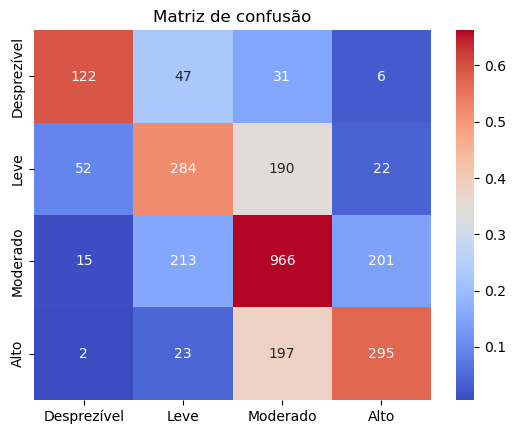

In [20]:
pred = bst.predict(X_test)

import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
matrix = np.zeros((4, 4), dtype=np.float64)
for i, (p, t) in enumerate(zip(pred, Y_test)):
    matrix[t, p] += 1

annot = np.copy(matrix)
for i, count in enumerate(Y_test.value_counts().sort_index()):
    matrix[i] /= count

sns.heatmap(matrix, cmap='coolwarm', robust=True, annot=annot, fmt='g', xticklabels=class_labels, yticklabels=class_labels).set_title("Matriz de confusão")

from sklearn.metrics import accuracy_score, classification_report
print(classification_report(Y_test.values, pred))